In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
df = pd.DataFrame(pd.read_csv("./acs2015_census.csv"))
df = df.dropna()
df.head()

,CensusTract,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga,1948,940,1008,0.9,87.4,7.7,0.3,...,0.5,2.3,2.1,25.0,943,77.1,18.3,4.6,0.0,5.4
1,1001020200,Alabama,Autauga,2156,1059,1097,0.8,40.4,53.3,0.0,...,0.0,0.7,0.0,23.4,753,77.0,16.9,6.1,0.0,13.3
2,1001020300,Alabama,Autauga,2968,1364,1604,0.0,74.5,18.6,0.5,...,0.0,0.0,2.5,19.6,1373,64.1,23.6,12.3,0.0,6.2
3,1001020400,Alabama,Autauga,4423,2172,2251,10.5,82.8,3.7,1.6,...,0.0,2.6,1.6,25.3,1782,75.7,21.2,3.1,0.0,10.8
4,1001020500,Alabama,Autauga,10763,4922,5841,0.7,68.5,24.8,0.0,...,0.0,0.6,0.9,24.8,5037,67.1,27.6,5.3,0.0,4.2


In [78]:
# Xác định các biến thành phần độc lập và biến giải thích
compositional_cols = ['Drive','Carpool','Transit','Walk','OtherTransp']

var_target = df['Income']
#family = family[(family != 0).all(axis=1)]

# chuyển dữ liệu thành phần
compositional_data = df[compositional_cols]
compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()


,Drive,Carpool,Transit,Walk,OtherTransp
0,0.922290,0.049080,0.0,0.005112,0.023517
1,0.862138,0.130869,0.0,0.000000,0.006993
2,0.971311,0.028689,0.0,0.000000,0.000000
3,0.880977,0.092574,0.0,0.000000,0.026450
4,0.887992,0.105954,0.0,0.000000,0.006054


In [79]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = clr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
#clr_compositional_data = pd.DataFrame(clr_compositional_data, columns=compositional_cols)
clr_compositional_data = pd.DataFrame(clr_compositional_data)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(compositional_data, var_target, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# In kết quả mô hình
print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 Income   No. Observations:                58181
Model:                            RLM   Df Residuals:                    58175
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 23 May 2024                                         
Time:                        14:06:31                                         
No. Iterations:                     9                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.401e+04     94.404    572.113      0.0

In [80]:
# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 27088.652922224912


In [81]:
# Độ lệch chuẩn của Total.Household.Income
std_income = np.std(y_test)
print(f"Standard Deviation of Total Household Income: {std_income}")

Standard Deviation of Total Household Income: 28504.600405655474


/tmp/ipykernel_11776/12606955.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Variables', palette='coolwarm')


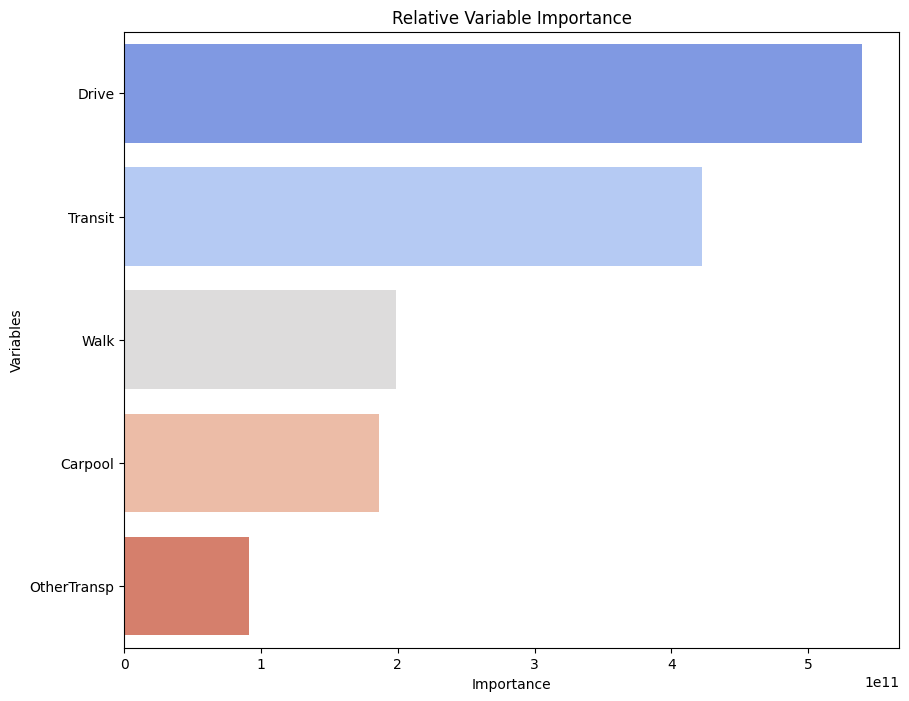

In [82]:
# Vẽ biểu đồ tầm quan trọng của biến
importance = rlm_results.params[1:]
variables = X_train.columns

importance_df = pd.DataFrame({
    'Variables': variables,
    'Importance': np.abs(importance)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Variables', palette='coolwarm')
plt.title('Relative Variable Importance')
plt.show()


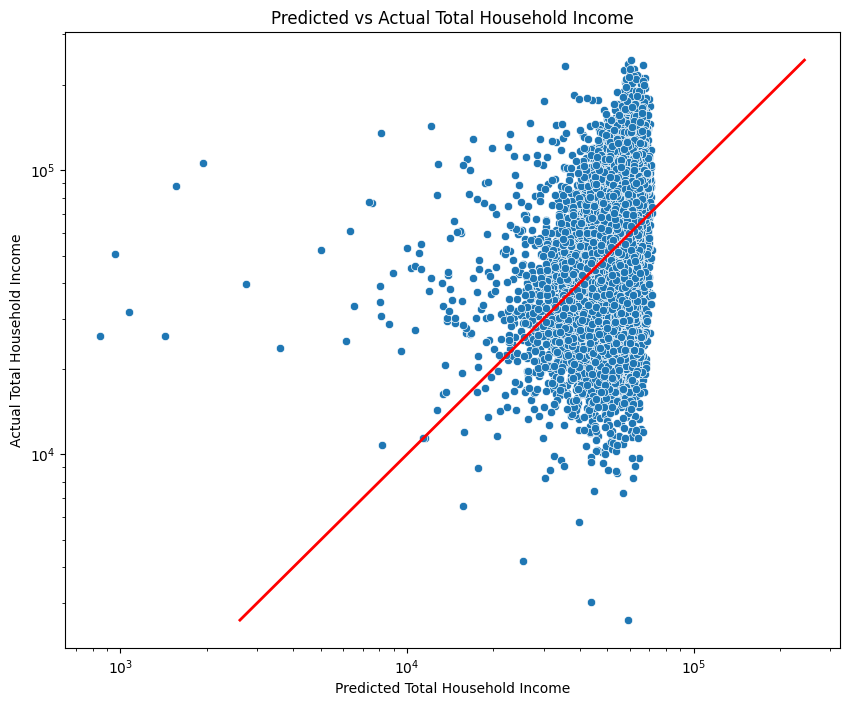

In [83]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted Total Household Income')
plt.ylabel('Actual Total Household Income')
plt.title('Predicted vs Actual Total Household Income')
plt.show()